In [19]:
import pandas
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
from torch.autograd import Variable
import torch.optim as optim
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [3]:
class Lin_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, act_function):
        super(Lin_Net, self).__init__()
        self.act_function = act_function
        
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # act_funtion = F.sigmoid oder F.relu
        x = self.act_function(self.lin1(x))
        x = self.act_function(self.lin2(x))
        x = self.lin3(x)
        return x

In [4]:
class MyDataset(D.Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = torch.from_numpy(x_tensor)
        self.y = torch.from_numpy(y_tensor)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [5]:
def make_data(dataset, features, batch_size, debug=False):
    datasets = []
    for file in dataset:
        datasets.append(pd.read_csv("../" + file))
    dataset = pd.concat(datasets, axis=0, ignore_index=True)
    
    target = dataset["affect"]
    dataset_full = dataset[["word_count", "upper_word_count", "ent_word_count", "h_count", "s_count", "a_count", "f_count", "cons_punct_count"]]
    dataset_nolex = dataset[["word_count", "upper_word_count", "ent_word_count", "cons_punct_count"]]
    dataset_lex = dataset[["h_count", "s_count", "a_count", "f_count"]]
    
    # make train and test sets
    if features == "full": 
        train_x, test_x, train_y, test_y = train_test_split(dataset_full, target, test_size=0.2)
    elif features == "nolex":
        train_x, test_x, train_y, test_y = train_test_split(dataset_nolex, target, test_size=0.2)
    elif features == "lex": 
        train_x, test_x, train_y, test_y = train_test_split(dataset_lex, target, test_size=0.2)

    # make data loaders
    train_data = MyDataset(train_x.to_numpy(), train_y.to_numpy())
    test_data = MyDataset(test_x.to_numpy(), test_y.to_numpy())
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    
    if debug: 
        dataset_full = dataset_full.iloc[:10]
        target = target[:10]
        train_x, test_x, train_y, test_y = train_test_split(dataset_full, target, test_size=0.8)
        train_data = MyDataset(train_x.to_numpy(), train_y.to_numpy())
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
        test_loader = DataLoader(dataset=train_data, batch_size=1)
    return train_loader, test_loader 

In [6]:
def log(summary, file):
    log = open(file, "a")
    log.write(summary)
    log.close()
    print(summary)

In [17]:
def train(train_loader, net, epochs, criterion, print_every, save_name, cuda, lr):
    open(save_name + "_train", "w").close()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.5)
    error_curve = []
    net.train()
    for epoch in range(epochs):
        for index, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.float(), targets.float()
            if cuda: 
                inputs = inputs.cuda()
                targets = targets.cuda()
                net = net.cuda()
            pred = net(inputs)    
            loss = criterion(pred, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if ((index) % print_every == 0):
                log("batch: {}/{} in epoch {}/{} \n... loss: {}\n".
                    format((index+1), len(train_loader), (epoch+1), epochs, loss.item()), 
                    save_name + "_train")
        # save network after every epoch
        torch.save(net.state_dict(), save_name + ".pt")  
        # after every epoch save the error
        error_curve.append([epoch, loss.item()])
    log("\n" + str(error_curve), save_name + "_train")
    plt.plot([item[0] for item in error_curve], [item[1] for item in error_curve])
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.savefig(save_name+"_train_error.png")

def test(test_loader, net, criterion, print_every, save_name, cuda):
    open(save_name + "_test", "w").close()
    confusion = []
    net.eval()
    loss_sum, correct, correct2 = 0, 0, 0
    for index, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.float(), targets.float()
        if cuda: 
            inputs = inputs.cuda()
            targets = targets.cuda()
            net = net.cuda()
        pred = net(inputs)
        pred_class = round(pred.item())
        loss_sum += criterion(pred, targets).item()
        confusion.append([targets.item(), pred_class])
        
        # correct? 
        if pred_class == targets.item():
            correct += 1
        
        if ((index) % print_every == 0):
            log("batch: {}/{}\n... correct: {}\n".
                format((index+1), len(test_loader), correct), 
                save_name + "_test")
           
    # give end report
    log("average test loss: {}, relative correct: {}\n\nconfusion:\n{}".
        format((loss_sum / len(test_loader)), (correct / len(test_loader)),str(confusion)), 
        save_name + "_test")

In [11]:
# create variables 
print("creating variables")
emotion_dataset = ["emotion_classification_1_clean.csv", "emotion_classification_2_clean.csv", "emotion_classification_3_clean.csv", "emotion_classification_4_clean.csv", "emotion_classification_5_clean.csv", "emotion_classification_6_clean.csv", "emotion_classification_7_clean.csv", "emotion_classification_8_clean.csv"]
tweet_dataset = ["crowdflower_clean.csv", "emoint_clean.csv", "tec_clean.csv"]
act_function = torch.sigmoid
criterion = nn.MSELoss()
cuda = torch.cuda.is_available()
batch_size = 25

creating variables


batch: 1/1 in epoch 1/1000 
... loss: 0.2837662994861603

batch: 1/1 in epoch 2/1000 
... loss: 0.5006978511810303

batch: 1/1 in epoch 3/1000 
... loss: 1.2827690839767456

batch: 1/1 in epoch 4/1000 
... loss: 4.073252201080322

batch: 1/1 in epoch 5/1000 
... loss: 10.667582511901855

batch: 1/1 in epoch 6/1000 
... loss: 11.398224830627441

batch: 1/1 in epoch 7/1000 
... loss: 0.32193297147750854

batch: 1/1 in epoch 8/1000 
... loss: 0.6663562655448914

batch: 1/1 in epoch 9/1000 
... loss: 0.6582034826278687

batch: 1/1 in epoch 10/1000 
... loss: 0.3842248320579529

batch: 1/1 in epoch 11/1000 
... loss: 0.26299160718917847

batch: 1/1 in epoch 12/1000 
... loss: 0.25382012128829956

batch: 1/1 in epoch 13/1000 
... loss: 0.2635621428489685

batch: 1/1 in epoch 14/1000 
... loss: 0.2625691592693329

batch: 1/1 in epoch 15/1000 
... loss: 0.2563020884990692

batch: 1/1 in epoch 16/1000 
... loss: 0.2522393763065338

batch: 1/1 in epoch 17/1000 
... loss: 0.25127288699150085

bat

batch: 1/1 in epoch 163/1000 
... loss: 0.25060275197029114

batch: 1/1 in epoch 164/1000 
... loss: 0.2506002187728882

batch: 1/1 in epoch 165/1000 
... loss: 0.2505977153778076

batch: 1/1 in epoch 166/1000 
... loss: 0.25059521198272705

batch: 1/1 in epoch 167/1000 
... loss: 0.25059273838996887

batch: 1/1 in epoch 168/1000 
... loss: 0.2505902647972107

batch: 1/1 in epoch 169/1000 
... loss: 0.2505878210067749

batch: 1/1 in epoch 170/1000 
... loss: 0.2505853772163391

batch: 1/1 in epoch 171/1000 
... loss: 0.2505829334259033

batch: 1/1 in epoch 172/1000 
... loss: 0.2505805492401123

batch: 1/1 in epoch 173/1000 
... loss: 0.2505781352519989

batch: 1/1 in epoch 174/1000 
... loss: 0.2505757808685303

batch: 1/1 in epoch 175/1000 
... loss: 0.25057339668273926

batch: 1/1 in epoch 176/1000 
... loss: 0.250571072101593

batch: 1/1 in epoch 177/1000 
... loss: 0.2505687177181244

batch: 1/1 in epoch 178/1000 
... loss: 0.25056639313697815

batch: 1/1 in epoch 179/1000 
... lo

batch: 1/1 in epoch 301/1000 
... loss: 0.25036242604255676

batch: 1/1 in epoch 302/1000 
... loss: 0.25036126375198364

batch: 1/1 in epoch 303/1000 
... loss: 0.25036007165908813

batch: 1/1 in epoch 304/1000 
... loss: 0.250358909368515

batch: 1/1 in epoch 305/1000 
... loss: 0.2503577470779419

batch: 1/1 in epoch 306/1000 
... loss: 0.25035661458969116

batch: 1/1 in epoch 307/1000 
... loss: 0.25035545229911804

batch: 1/1 in epoch 308/1000 
... loss: 0.2503543198108673

batch: 1/1 in epoch 309/1000 
... loss: 0.2503531873226166

batch: 1/1 in epoch 310/1000 
... loss: 0.25035202503204346

batch: 1/1 in epoch 311/1000 
... loss: 0.2503509223461151

batch: 1/1 in epoch 312/1000 
... loss: 0.2503497898578644

batch: 1/1 in epoch 313/1000 
... loss: 0.25034865736961365

batch: 1/1 in epoch 314/1000 
... loss: 0.2503475546836853

batch: 1/1 in epoch 315/1000 
... loss: 0.25034645199775696

batch: 1/1 in epoch 316/1000 
... loss: 0.2503453493118286

batch: 1/1 in epoch 317/1000 
...

batch: 1/1 in epoch 465/1000 
... loss: 0.2502244710922241

batch: 1/1 in epoch 466/1000 
... loss: 0.25022387504577637

batch: 1/1 in epoch 467/1000 
... loss: 0.2502232789993286

batch: 1/1 in epoch 468/1000 
... loss: 0.25022271275520325

batch: 1/1 in epoch 469/1000 
... loss: 0.2502221167087555

batch: 1/1 in epoch 470/1000 
... loss: 0.25022152066230774

batch: 1/1 in epoch 471/1000 
... loss: 0.2502209544181824

batch: 1/1 in epoch 472/1000 
... loss: 0.2502203583717346

batch: 1/1 in epoch 473/1000 
... loss: 0.25021979212760925

batch: 1/1 in epoch 474/1000 
... loss: 0.2502192258834839

batch: 1/1 in epoch 475/1000 
... loss: 0.25021862983703613

batch: 1/1 in epoch 476/1000 
... loss: 0.25021806359291077

batch: 1/1 in epoch 477/1000 
... loss: 0.2502174973487854

batch: 1/1 in epoch 478/1000 
... loss: 0.25021693110466003

batch: 1/1 in epoch 479/1000 
... loss: 0.25021636486053467

batch: 1/1 in epoch 480/1000 
... loss: 0.2502157986164093

batch: 1/1 in epoch 481/1000 
..

batch: 1/1 in epoch 618/1000 
... loss: 0.2501537799835205

batch: 1/1 in epoch 619/1000 
... loss: 0.25015342235565186

batch: 1/1 in epoch 620/1000 
... loss: 0.2501530647277832

batch: 1/1 in epoch 621/1000 
... loss: 0.25015270709991455

batch: 1/1 in epoch 622/1000 
... loss: 0.2501523494720459

batch: 1/1 in epoch 623/1000 
... loss: 0.25015202164649963

batch: 1/1 in epoch 624/1000 
... loss: 0.250151664018631

batch: 1/1 in epoch 625/1000 
... loss: 0.25015130639076233

batch: 1/1 in epoch 626/1000 
... loss: 0.2501509487628937

batch: 1/1 in epoch 627/1000 
... loss: 0.2501506209373474

batch: 1/1 in epoch 628/1000 
... loss: 0.25015026330947876

batch: 1/1 in epoch 629/1000 
... loss: 0.2501499056816101

batch: 1/1 in epoch 630/1000 
... loss: 0.25014957785606384

batch: 1/1 in epoch 631/1000 
... loss: 0.2501492202281952

batch: 1/1 in epoch 632/1000 
... loss: 0.2501488924026489

batch: 1/1 in epoch 633/1000 
... loss: 0.2501485347747803

batch: 1/1 in epoch 634/1000 
... l

batch: 1/1 in epoch 783/1000 
... loss: 0.25010693073272705

batch: 1/1 in epoch 784/1000 
... loss: 0.25010672211647034

batch: 1/1 in epoch 785/1000 
... loss: 0.25010648369789124

batch: 1/1 in epoch 786/1000 
... loss: 0.2501062750816345

batch: 1/1 in epoch 787/1000 
... loss: 0.2501060366630554

batch: 1/1 in epoch 788/1000 
... loss: 0.2501058280467987

batch: 1/1 in epoch 789/1000 
... loss: 0.250105619430542

batch: 1/1 in epoch 790/1000 
... loss: 0.2501053810119629

batch: 1/1 in epoch 791/1000 
... loss: 0.2501051723957062

batch: 1/1 in epoch 792/1000 
... loss: 0.2501049339771271

batch: 1/1 in epoch 793/1000 
... loss: 0.25010472536087036

batch: 1/1 in epoch 794/1000 
... loss: 0.25010451674461365

batch: 1/1 in epoch 795/1000 
... loss: 0.25010430812835693

batch: 1/1 in epoch 796/1000 
... loss: 0.25010406970977783

batch: 1/1 in epoch 797/1000 
... loss: 0.2501038610935211

batch: 1/1 in epoch 798/1000 
... loss: 0.2501036524772644

batch: 1/1 in epoch 799/1000 
... 

batch: 1/1 in epoch 929/1000 
... loss: 0.25007957220077515

batch: 1/1 in epoch 930/1000 
... loss: 0.2500793933868408

batch: 1/1 in epoch 931/1000 
... loss: 0.2500792443752289

batch: 1/1 in epoch 932/1000 
... loss: 0.25007909536361694

batch: 1/1 in epoch 933/1000 
... loss: 0.250078946352005

batch: 1/1 in epoch 934/1000 
... loss: 0.2500787675380707

batch: 1/1 in epoch 935/1000 
... loss: 0.25007861852645874

batch: 1/1 in epoch 936/1000 
... loss: 0.2500784695148468

batch: 1/1 in epoch 937/1000 
... loss: 0.25007832050323486

batch: 1/1 in epoch 938/1000 
... loss: 0.2500781714916229

batch: 1/1 in epoch 939/1000 
... loss: 0.2500779926776886

batch: 1/1 in epoch 940/1000 
... loss: 0.25007787346839905

batch: 1/1 in epoch 941/1000 
... loss: 0.2500776946544647

batch: 1/1 in epoch 942/1000 
... loss: 0.2500775456428528

batch: 1/1 in epoch 943/1000 
... loss: 0.25007742643356323

batch: 1/1 in epoch 944/1000 
... loss: 0.2500772476196289

batch: 1/1 in epoch 945/1000 
... l

batch: 1/2
... correct: 1

average test loss: 0.2417515516281128, relative correct: 1.0

confusion:
[[0.0, 0], [1.0, 1]]
... done


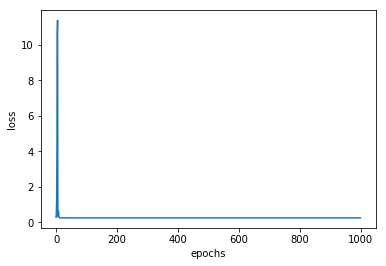

In [18]:
# debug set
net_full = Lin_Net(8, 1, 64, act_function)
train_loader_debug, test_loader_debug = make_data(emotion_dataset, "full", batch_size, True)
train(train_loader_debug, net_full, 1000, criterion, 100, "../logs/mse_debug", cuda, 0.1)
test(test_loader_debug, net_full, criterion, 100, "../logs/mse_debug", cuda)

print("... done")

In [8]:
print("-------- net_lin_emotion_full")
#net_full = Lin_Net(8, 1, 64, act_function)
#train_loader_emotion_full, test_loader_emotion_full = make_data(emotion_dataset, "full", batch_size)
#train(train_loader_emotion_full, net_full, 100, criterion, 5000, "../logs/mse_emotion_full", cuda, 0.1)
#test(test_loader_emotion_full, net_full, criterion, 1000, "../logs/mse_emotion_full")

print("-------- net_lin_emotion_nolex")
#net_half = Lin_Net(4, 1, 64, act_function)
#train_loader_emotion_nolex, test_loader_emotion_nolex = make_data(emotion_dataset, "nolex", batch_size)
#train(train_loader_emotion_nolex, net_half, 100, criterion, 5000, "../logs/mse_emotion_nolex", cuda, 0.1)
#test(test_loader_emotion_nolex, net_half, criterion, 1000, "../logs/mse_emotion_nolex")

print("-------- net_lin_emotion_lex")
#net_half = Lin_Net(4, 1, 64, act_function)
#train_loader_emotion_lex, test_loader_emotion_lex = make_data(emotion_dataset, "lex", batch_size)
#train(train_loader_emotion_lex, net_half, 100, criterion, 5000, "../logs/mse_emotion_lex", cuda, 0.1)
#test(test_loader_emotion_lex, net_half, criterion, 1000, "../logs/mse_emotion_lex")

print("-------- net_lin_tweet_full")
#net_full = Lin_Net(8, 1, 64, act_function)
#train_loader_tweet_full, test_loader_tweet_full = make_data(tweet_dataset, "full", batch_size)
#train(train_loader_tweet_full, net_full, 100, criterion, 5000, "../logs/mse_tweet_full", cuda, 0.1)
#test(test_loader_tweet_full, net_full, criterion, 1000, "../logs/mse_tweet_full")

print("-------- net_lin_tweet_nolex")
#net_half = Lin_Net(4, 1, 64, act_function)
#train_loader_tweet_nolex, test_loader_tweet_nolex = make_data(tweet_dataset, "nolex", batch_size)
#train(train_loader_tweet_nolex, net_half, 100, criterion, 5000, "../logs/mse_tweet_nolex", cuda, 0.1)
#test(test_loader_tweet_nolex, net_half, criterion, 1000, "../logs/mse_tweet_nolex")

print("-------- net_lin_tweet_lex")
#net_half = Lin_Net(4, 1, 64, act_function)
#train_loader_tweet_lex, test_loader_tweet_lex = make_data(tweet_dataset, "lex", batch_size)
#train(train_loader_tweet_lex, net_half, 100, criterion, 5000, "../logs/mse_tweet_lex", cuda, 0.1)
#test(test_loader_tweet_lex, net_half, criterion, 1000, "../logs/mse_tweet_lex")

print("... done")